In [50]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

In [51]:
import sys
sys.path.append('../')

In [52]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import simple_PQC_pennylane

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data


In [53]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    device = torch.device("mps")
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    device = torch.device("cuda")
else:
    print('Torch running on CPU')
    device = torch.device("cpu")

Torch running on Apple GPU


In [54]:
NUM_SHOTS = 10**4
NUM_QUBITS = 5
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)

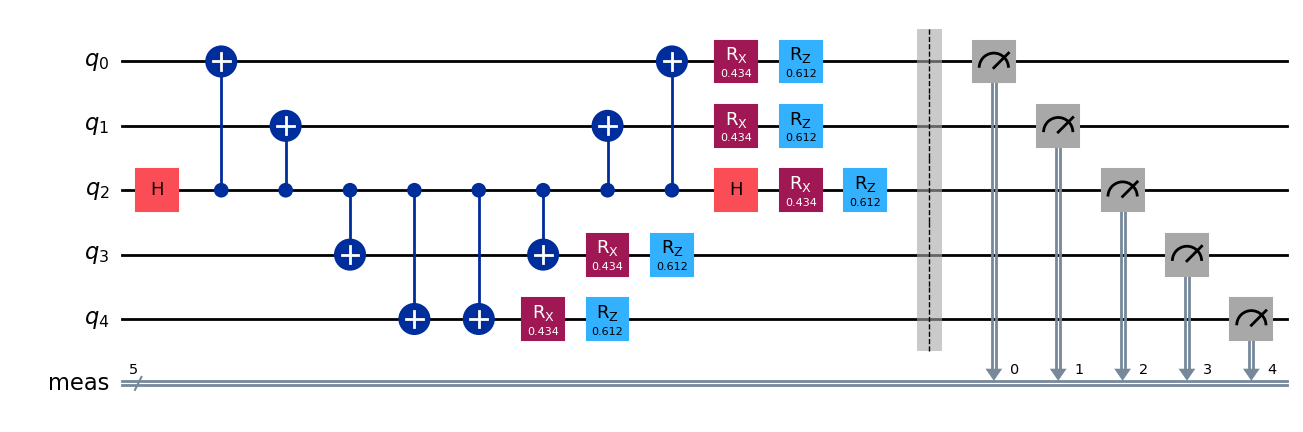

In [55]:
test_circ = append_inverse_to_quantum_circuit(custom_ghz(5, 2))
test_params = torch.rand(3)
# print(test_params)
# test_circ = test_circ.compose(test_circ.inverse())
test_circ_pqc = append_pqc_to_quantum_circuit(test_circ, test_params)
test_circ_pqc.draw('mpl')

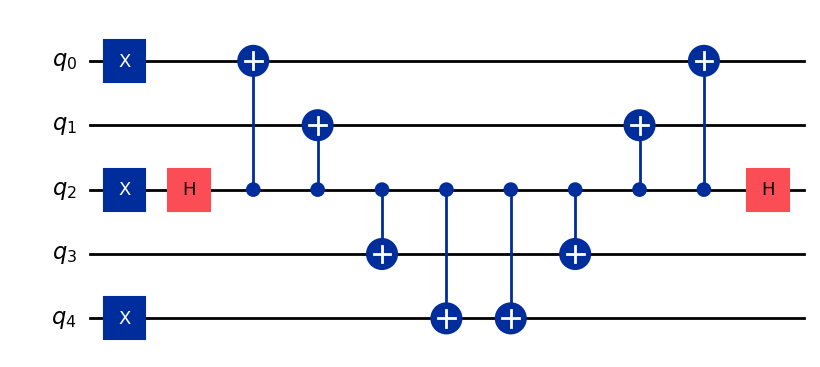

In [56]:
mcirc = get_circuit_for_model(INPUT_BITS, custom_ghz(5,2))
mcirc.draw('mpl')

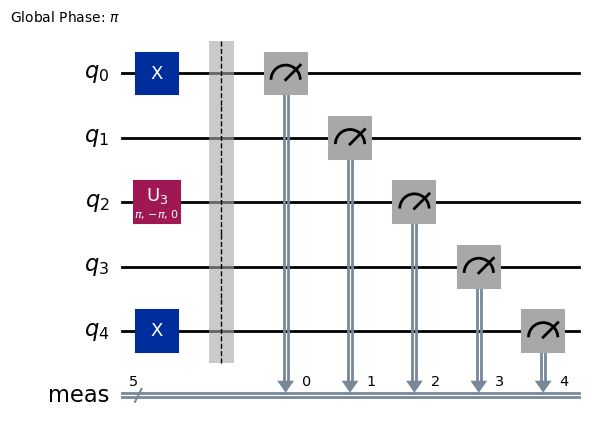

In [57]:
mcirc_measured = mcirc.measure_all(inplace=False)
ideal_sim = AerSimulator()
transpiled_circ = transpile(mcirc_measured, ideal_sim)
transpiled_circ.draw('mpl')

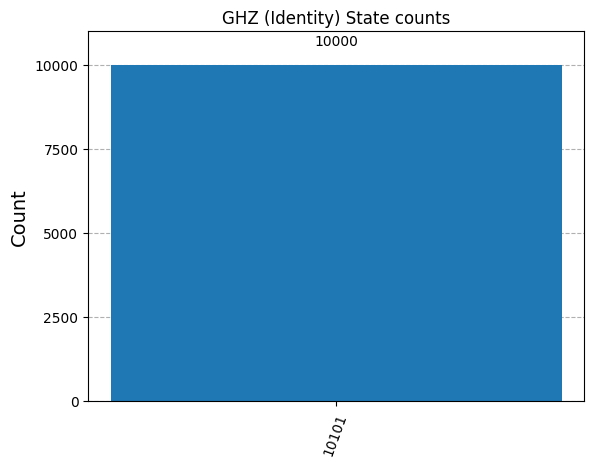

In [58]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='GHZ (Identity) State counts')

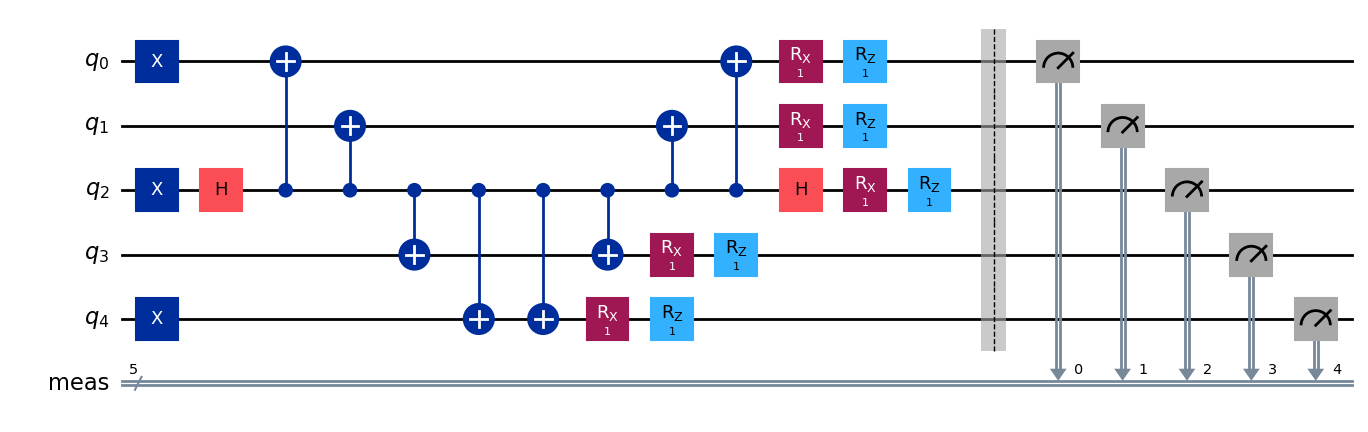

In [59]:
mcirc_pqc = append_pqc_to_quantum_circuit(mcirc, torch.ones(mcirc.num_qubits))
mcirc_pqc.draw('mpl')

In [60]:
ideal_counts = get_ideal_shots(input=INPUT_BITS, shots=NUM_SHOTS)
measured_counts = run_circuit_sim(circuit=mcirc_pqc, simulator=noisy_sim, num_shots=NUM_SHOTS)

print(ideal_counts)
print(measured_counts)

print(torch.dist(ideal_counts, measured_counts))

tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.])
tensor([  87,  258,   30,   75,  260,  735,   88,  269,   28,   68,   11,   36,
          64,  287,   25,   79,  224,  866,   64,  276,  784, 2501,  252,  800,
          73,  245,   29,  106,  210,  812,   76,  282])
tensor(7756.8345)


In [61]:
class SimpleCustomQuantumModel(nn.Module):
    def __init__(self, num_params:int, base_circuit: QuantumCircuit, simulator:AerSimulator=fakeAthensV2_backend, num_shots=NUM_SHOTS, circuit_runner = run_circuit_sim):
        super().__init__()

        self.pqc_params = nn.Parameter(torch.rand(num_params))
        self.simulator = simulator
        self.transpile = transpile
        self.num_shots = num_shots
        self.runner = circuit_runner
        self.base_circuit = base_circuit
        self.pennylane_dev = qml.device("default.qubit", wires=self.base_circuit.num_qubits)

        pass

    
    def forward(self, unitary:Operator):
        """
        @param circuit: The quantum circuit with the input and it's inverse appended. 
        """    
        # circuit = circuit.remove_final_measurements(inplace=False)
        # circuit_pqc = append_pqc_to_quantum_circuit(circuit, self.pqc_params)
        # measured_tensor = self.runner(circuit_pqc, self.simulator, self.num_shots)

        # return measured_tensor

        qnode = self.make_pennylane_qnode()
        probs = qnode(self.pqc_params, unitary, self.base_circuit.num_qubits)
        # shots_scaled = probs * self.num_shots

        return probs

    

    
    def make_pennylane_qnode(self):
        dev = qml.device("default.qubit", wires=self.base_circuit.num_qubits)

        @qml.qnode(dev, interface="torch", diff_method="backprop")
        def pennylane_pqc_circ(params, unitary, num_qubits):
            qml.QubitUnitary(unitary, wires=range(num_qubits))  # fixed input/inverse
            simple_PQC_pennylane(num_qubits=num_qubits, params=params)
            
            return qml.probs(wires=range(num_qubits))

        return pennylane_pqc_circ



        


In [62]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=5000, prob_dist=True)
print(len(ideal_data[10][1]))

32


In [63]:
ghz_circuit = custom_ghz(NUM_QUBITS, 2)
pqc_model = SimpleCustomQuantumModel(num_params=2, num_shots=NUM_SHOTS, base_circuit=ghz_circuit)

optimizer = torch.optim.AdamW(
    pqc_model.parameters(), 
    lr=1e-2,              # or 5e-4 if training is unstable
    # betas=(0.9, 0.99),    # slower decay of second moment (more stable for PQCs)
    # eps=1e-8,             # default, helps avoid division by zero
    # weight_decay=1e-4     # some regularization to avoid overfitting
)

loss_fn = nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(device)

mps


In [64]:
param_list = []
loss_list = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i}')
    pqc_model.train()
    ctr = 0
    for bitstring, ideal in ideal_data:
        ctr += 1
        optimizer.zero_grad()

        # measured = pqc_model(get_circuit_for_model(bitstring, ghz_circuit))
        model_unitary = get_unitary_for_model_pennylane(bitstring, pqc_model.base_circuit)

        # print(len(measured), len(ideal))
        measured = pqc_model(model_unitary)

        ideal = ideal.float().to(device)
        measured = measured.float().to(device)
        
        loss = loss_fn(measured, ideal)

        loss.backward()
        optimizer.step()

        param_values = (pqc_model.pqc_params.detach().cpu().numpy()) % (2 * np.pi)
        param_list.append(param_values)


        if (ctr) % (len(ideal_data) // 10) == 0:
            
            print(f'Count {ctr}, Loss: {loss:.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')

    # scheduler.step()

    

Starting Epoch 0
Count 500, Loss: 0.0315, Params: Parameter containing:
tensor([1.1038, 0.8598], requires_grad=True)
Count 1000, Loss: 0.0228, Params: Parameter containing:
tensor([1.2227, 0.8153], requires_grad=True)
Count 1500, Loss: 0.0291, Params: Parameter containing:
tensor([1.2077, 0.7644], requires_grad=True)
Count 2000, Loss: 0.0293, Params: Parameter containing:
tensor([1.1832, 0.7192], requires_grad=True)
Count 2500, Loss: 0.0311, Params: Parameter containing:
tensor([1.1432, 0.6823], requires_grad=True)
Count 3000, Loss: 0.0212, Params: Parameter containing:
tensor([1.1562, 0.6517], requires_grad=True)
Count 3500, Loss: 0.0309, Params: Parameter containing:
tensor([1.0280, 0.6157], requires_grad=True)
Count 4000, Loss: 0.0220, Params: Parameter containing:
tensor([1.1861, 0.5797], requires_grad=True)
Count 4500, Loss: 0.0299, Params: Parameter containing:
tensor([1.1148, 0.5475], requires_grad=True)
Count 5000, Loss: 0.0315, Params: Parameter containing:
tensor([1.0983, 0.5

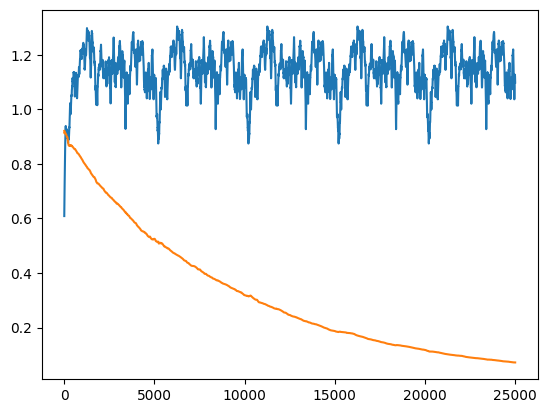

In [65]:
param_arr = np.array(param_list).transpose()
plt.plot([i for i in range(param_arr.shape[1])], *param_arr)

In [66]:
pqc_model.pqc_params

Parameter containing:
tensor([1.0984, 0.0720], requires_grad=True)

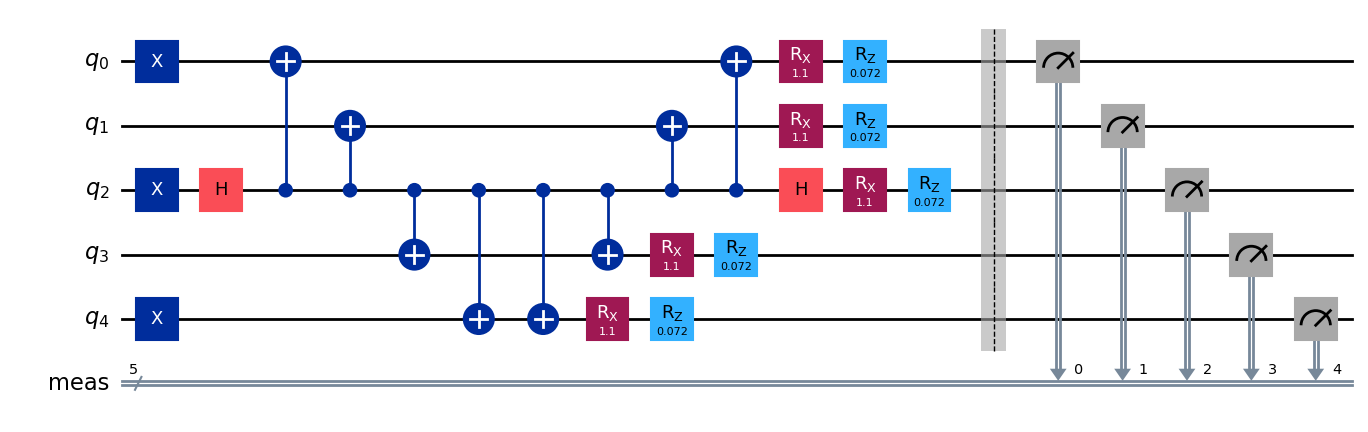

In [67]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params)
mcirc_post.draw('mpl')

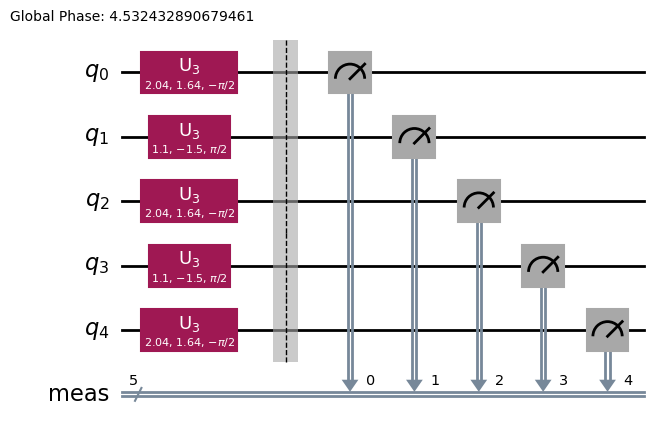

In [68]:
ideal_sim = AerSimulator()
transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

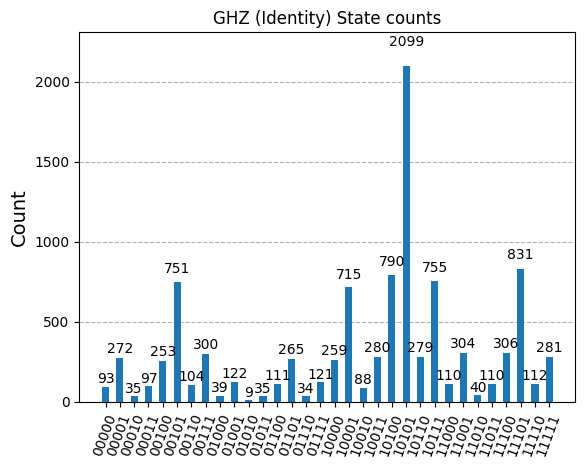

In [69]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

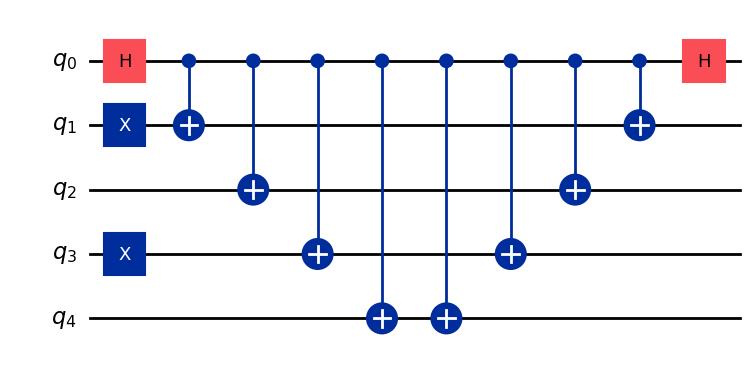

In [70]:
mcirc = get_circuit_for_model('01010', custom_ghz(5,0))
mcirc.draw('mpl')

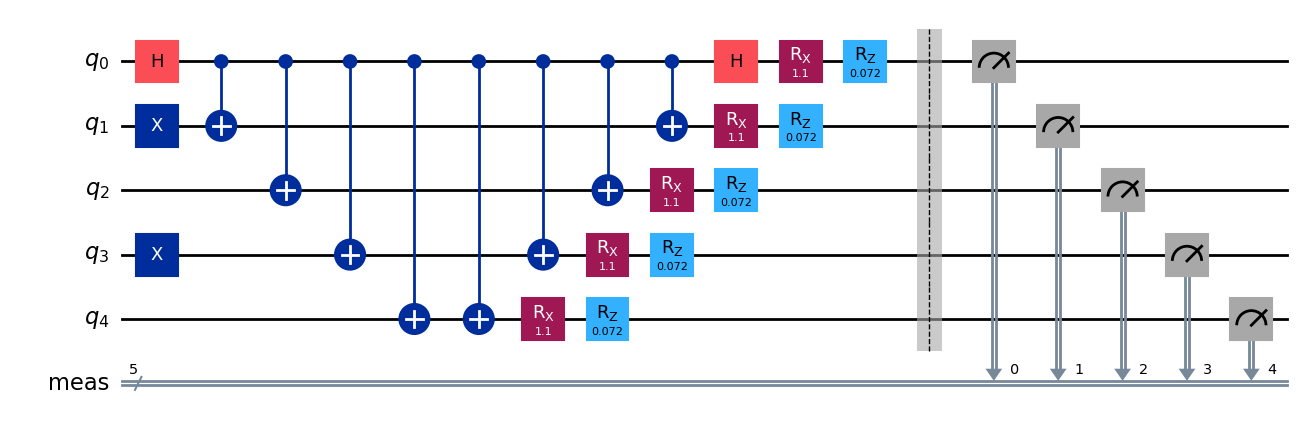

In [71]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params)
mcirc_post.draw('mpl')

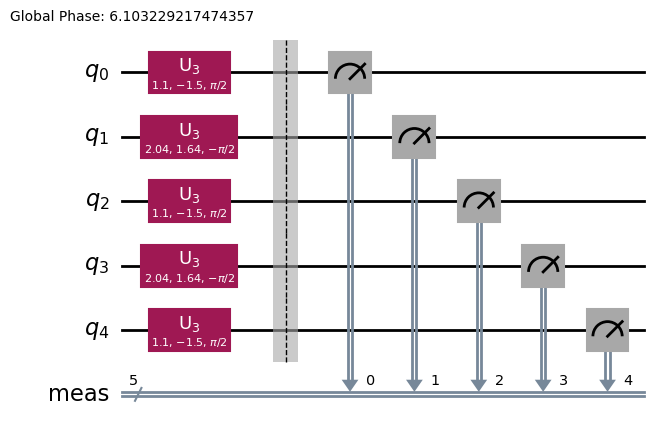

In [72]:
transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

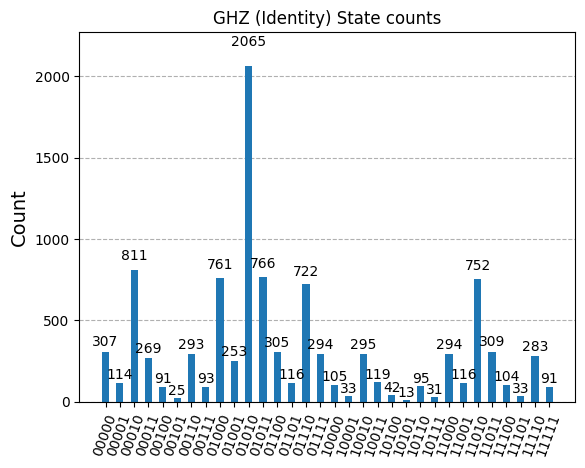

In [73]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')